In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [2]:
X_dim = 6
c_dim = 21
gridSize = 100
z_dim = 5

bs = 256

In [3]:
import torch.nn.functional as F
   
class AttentionVAE(nn.Module):
    def __init__(self, sample_size, grid_size, cond_size, encoder_layer_sizes, latent_size, decoder_layer_sizes):
        super(AttentionVAE, self).__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        
        self.latent_size = latent_size
        self.condNN = CondNN(sample_size, grid_size, cond_size)
        self.encoder = Encoder(sample_size + cond_size, encoder_layer_sizes, latent_size)
        self.decoder = Decoder(latent_size + cond_size, decoder_layer_sizes, sample_size)

    def condnn(self,startend, occ):
        return self.condNN(startend, occ)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, startend, occ):
        c, _ = self.condnn(startend, occ)
        mu, logvar = self.encode(torch.cat((x, c), dim=-1))
        z = self.reparameterize(mu, logvar)
        return self.decode(torch.cat((z, c), dim=-1)), mu, logvar
    
    def inference(self, startend, occ, num_viz):
        c, alpha = self.condnn(startend, occ)
        z = torch.randn(num_viz, self.latent_size, device = c.device)
        return self.decode(torch.cat((z, c), dim=-1)), alpha
    
class Encoder(nn.Module):
    def __init__(self, input_size, layer_sizes, latent_size):
        super(Encoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))

        self.sequential = nn.Sequential(*modules)
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x):
        x = self.sequential(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, input_size, layer_sizes, sample_size):
        super(Decoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))
        modules.append(nn.Linear(layer_sizes[-1], sample_size))
        
        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)


class CondNN(nn.Module):
    def __init__(self, sampleSize, gridSize, outSize, encoder_dim=48, condition_dim=12, attention_dim=48):
        super(CondNN, self).__init__()
        self.CnnEncoder = CnnEncoder(gridSize)
        self.Attention = Attention(encoder_dim + 2, condition_dim, attention_dim) # + 2 for position
        self.fc1 = nn.Linear(attention_dim + 2 + condition_dim, outSize)

    def forward(self, startend, occ):
        encoder_out = self.CnnEncoder(occ)
        attention_weighted_encoding, alpha = self.Attention(encoder_out, startend)
        x = torch.cat((attention_weighted_encoding, startend), dim=-1)
        x = self.fc1(x)
        return x, alpha

class CnnEncoder(nn.Module):
    def __init__(self, gridSize, encoded_image_size=11):
        super(CnnEncoder, self).__init__()
        self.gridSize = gridSize
        self.encoded_image_size = encoded_image_size
        self.cnn = nn.Sequential(
                    nn.Conv2d(1, 6, 5, padding=(2,2)),
                    nn.MaxPool2d(3,3),
                    nn.Conv2d(6, 16, 5, padding=(2,2)),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(16, 48, 5, padding=(2,2)),
                    nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)))
            
    def forward(self, images):
        out = self.cnn(images)
        out = out.permute(0, 2, 3, 1) # (batch_size, encoded_image_size, encoded_image_size, 48)
        return out
            
class Attention(nn.Module):
    def __init__(self, encoder_dim, condition_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.condition_att = nn.Linear(condition_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.position = self.initPosition()
    
    def initPosition(self):
        x = np.linspace(0, 10, 11, dtype='float32')
        y = np.linspace(0, 10, 11, dtype='float32')
        xv, yv = np.meshgrid(x,y)
        xv, yv = xv.reshape((1,-1, 1)), yv.reshape((1,-1, 1))
        position = torch.from_numpy(np.concatenate((xv, yv), axis = 2))
        
        return position
        
        
    def forward(self, encoder_out, condition):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        self.position = self.position.to(encoder_out.device)
        self.position = self.position.expand(batch_size, self.position.shape[1], self.position.shape[2])
        encoder_out = torch.cat((encoder_out, self.position), dim = 2)
        
        att1 = self.encoder_att(encoder_out)
        att2 = self.condition_att(condition)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
            
        return attention_weighted_encoding, alpha

In [4]:
torch.cuda.empty_cache()

model = AttentionVAE(sample_size = X_dim, 
                  grid_size = gridSize, 
                  cond_size = 21,
                  encoder_layer_sizes = [512,1024,512], 
                  latent_size = z_dim, 
                  decoder_layer_sizes = [512,1024,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load('checkpoints/attention.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

model.eval()

AttentionVAE(
  (condNN): CondNN(
    (CnnEncoder): CnnEncoder(
      (cnn): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (5): AdaptiveAvgPool2d(output_size=(11, 11))
      )
    )
    (Attention): Attention(
      (encoder_att): Linear(in_features=50, out_features=48, bias=True)
      (condition_att): Linear(in_features=12, out_features=48, bias=True)
      (full_att): Linear(in_features=48, out_features=1, bias=True)
      (relu): ReLU()
      (softmax): Softmax(dim=1)
    )
    (fc1): Linear(in_features=62, out_features=21, bias=True)
  )
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Line

In [5]:
from data.AttentionDataset import AttentionDataset

test_loader = DataLoader(AttentionDataset(np_file_data = 'data/NarrowPassage/narrowDataOcc100.npz',
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = False),
                          batch_size = bs, shuffle=True, drop_last = True)

8712


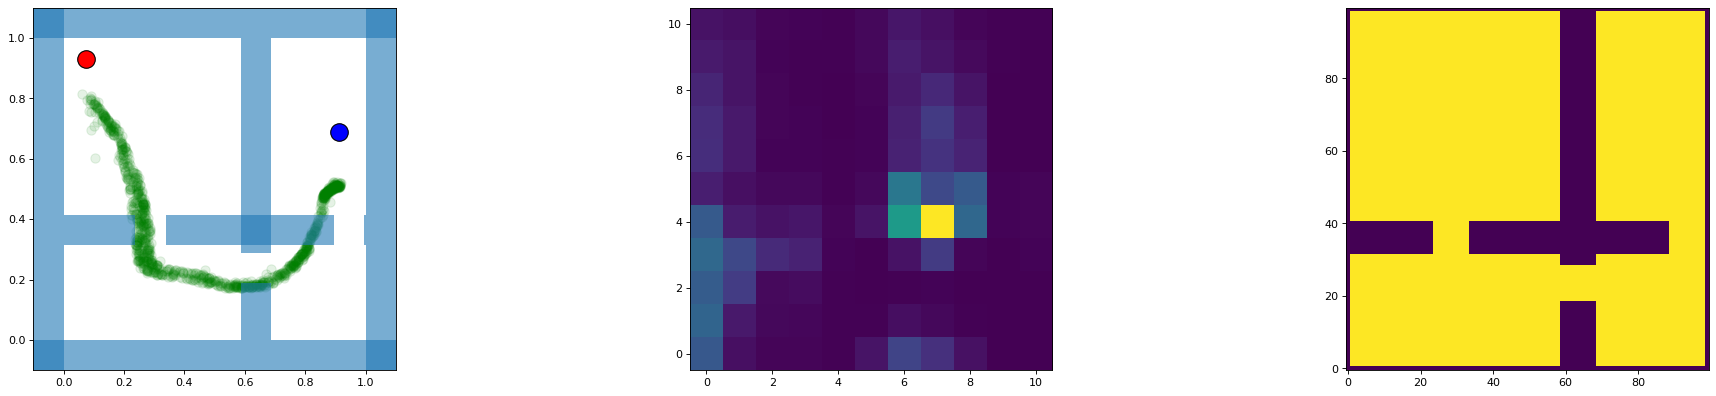

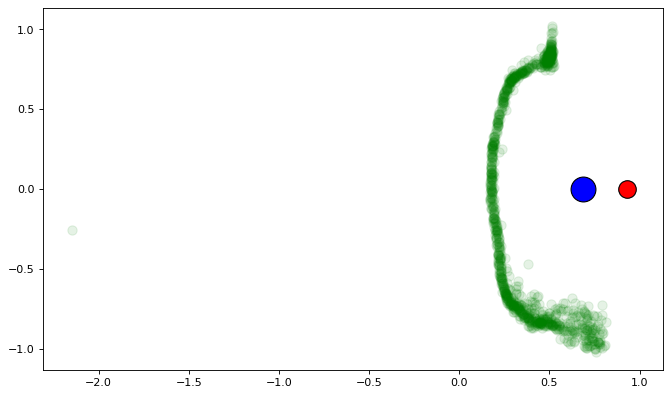

In [6]:
test_data = test_loader.dataset
viz_idx =   torch.randint(0,len(test_data),[1]).item()  
viz_idx = 8712
print(viz_idx)

_, con, startend, occ = test_data[viz_idx]
startend, occ = torch.tensor(startend), torch.unsqueeze(torch.tensor(occ), 0)

model.eval()
y_viz = torch.randn(1,6).to(device)
for i in range(0, 4):
    num_viz = 256
    y_viz_p, alpha = model.inference(startend.expand(num_viz, X_dim * 2).to(device), 
                            occ.expand(num_viz, 1, gridSize, gridSize).to(device), num_viz)
    torch.cuda.empty_cache()
    y_viz = torch.cat((y_viz_p, y_viz), dim = 0)

y_viz=y_viz.cpu().detach().numpy()
occ=occ.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed, plotSampleAttention

torch.cuda.empty_cache()

occ = occ[0].reshape(100,100)
a = alpha[0].reshape(11,11)
a = a.cpu().detach().numpy()

plotSampleAttention(y_viz, con, occ, a)
plotSpeed(y_viz, con)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

def isSampleFree(sample, obs, dimW):
    for o in range(0, obs.shape[0] // (2 * dimW)):
        isFree = 0
        for d in range(0, sample.shape[0]):
            if (sample[d] < obs[2 * dimW * o + d] or sample[d] > obs[2 * dimW * o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1


def gap2obs(condition):
    dw = 0.1
    dimW = 3
    gap1 = condition[0:3]
    gap2 = condition[3:6]
    gap3 = condition[6:9]

    obs1 = [0, gap1[1] - dw, -0.5, gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0] - dw, 0, -0.5, gap2[0], gap2[1], 1.5]
    obs3 = [gap2[0] - dw, gap2[1] + dw, -0.5, gap2[0], 1, 1.5]
    obs4 = [gap1[0] + dw, gap1[1] - dw, -0.5, gap3[0], gap1[1], 1.5]
    obs5 = [gap3[0] + dw, gap1[1] - dw, -0.5, 1, gap1[1], 1.5]
    obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
                 -0.1, -0.1, -0.5, 1.1, 0, 1.5,
                 -0.1, 1, -0.5, 1.1, 1.1, 1.5,
                 1, -0.1, -0.5, 1.1, 1.1, 1.5, ]
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)
    return obs, dimW


def getOccGrid(gridSize):
    gridPointsRange = np.linspace(0, 1, num=gridSize)
    occGridSamples = np.zeros([gridSize * gridSize, 2])
    idx = 0
    for i in gridPointsRange:
        for j in gridPointsRange:
            occGridSamples[idx, 0] = i
            occGridSamples[idx, 1] = j
            idx += 1
    return occGridSamples


def gap2occ(conditions, gridSize):
    obs, dimW = gap2obs(conditions)

    occGridSamples = getOccGrid(gridSize)
    occGrid = np.zeros(gridSize * gridSize)
    for i in range(0, gridSize * gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i, :], obs, dimW)
    return occGrid


def plotCondition(condition):
    fig1 = plt.figure(figsize=(10, 6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect='equal')
    obs, dimW = gap2obs(condition)
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        ax1.add_patch(
            patches.Rectangle(
                (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
                obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
                obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
                alpha=0.6
            ))
    gridSize = 11
    occGrid = gap2occ(condition, gridSize)

    occGridSamples = getOccGrid(gridSize)
    for i in range(0, gridSize * gridSize):  # plot occupancy grid
        if occGrid[i] == 0:
            plt.scatter(occGridSamples[i, 0], occGridSamples[i, 1], color="red", s=70, alpha=0.8)
        else:
            plt.scatter(occGridSamples[i, 0], occGridSamples[i, 1], color="green", s=70, alpha=0.8)
    init = condition[9:15]
    goal = condition[15:21]
    plt.scatter(init[0], init[1], color="red", s=250, edgecolors='black')  # init
    plt.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black')  # goal
    plt.show()


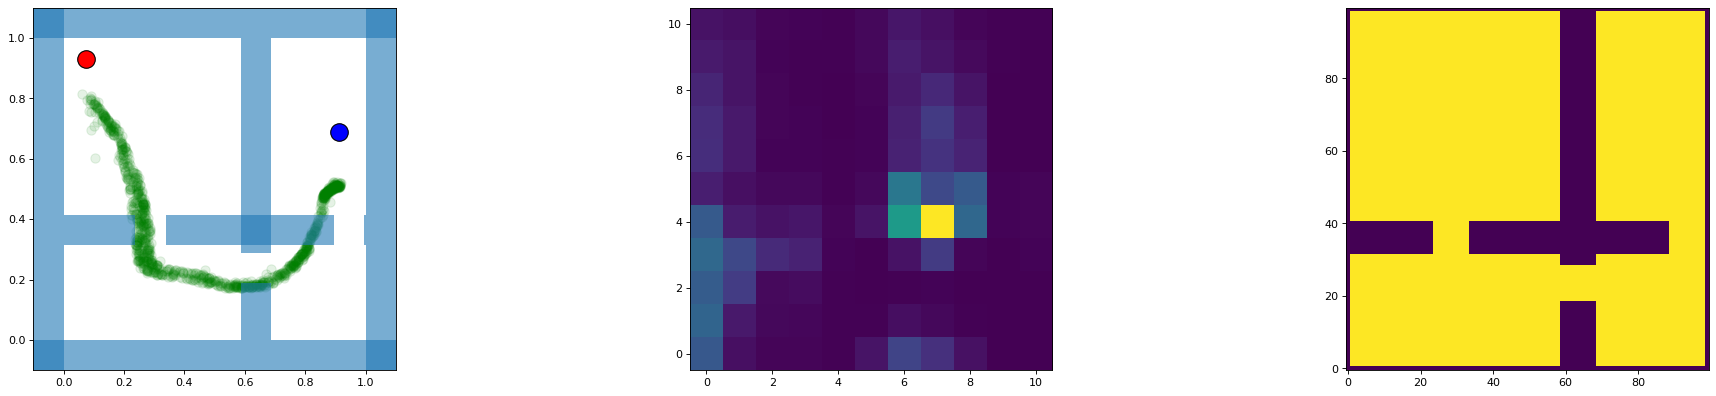

In [8]:
plotSampleAttention(y_viz, con, occ, a)

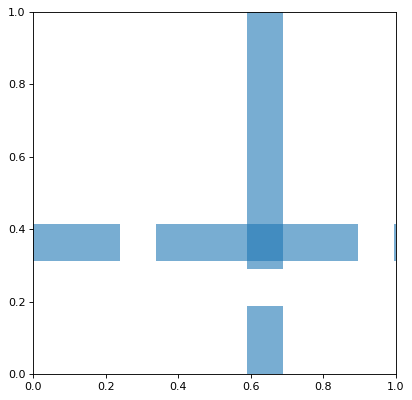

In [9]:
fig1 = plt.figure(figsize=(30, 6), dpi=80)
ax1 = fig1.add_subplot(131, aspect='equal')

obs, dimW = gap2obs(con)
for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
    ax1.add_patch(
        patches.Rectangle(
            (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
            obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
            obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
            alpha=0.6
        ))

In [10]:
dw = 0.1
dimW = 3
gap1 = con[0:3]
gap2 = con[3:6]
gap3 = con[6:9]

obs1 = [0, gap1[1] - dw, -0.5, gap1[0], gap1[1], 1.5]
obs2 = [gap2[0] - dw, 0, -0.5, gap2[0], gap2[1], 1.5]
obs3 = [gap2[0] - dw, gap2[1] + dw, -0.5, gap2[0], 1, 1.5]
obs4 = [gap1[0] + dw, gap1[1] - dw, -0.5, gap3[0], gap1[1], 1.5]
obs5 = [gap3[0] + dw, gap1[1] - dw, -0.5, 1, gap1[1], 1.5]

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)

In [11]:
import fcl

def addObs(obs, dimW):
    obs_fcl = []
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        width = obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW]
        height = obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1]
    #     width = height = 1
        ob = fcl.Box(width, height, 1)
        x = obs[i * 2 * dimW] + width/2
        y = obs[i * 2 * dimW + 1] + height/2
    #     x = y = 0
        T = np.array([x, y, 0])
        t = fcl.Transform(T)
        co = fcl.CollisionObject(ob, t)
        obs_fcl.append(co)
        print("x: ", x, " y: ", y, " width: ", width, " height: ", height)

    obs_manager = fcl.DynamicAABBTreeCollisionManager()
    obs_manager.registerObjects(obs_fcl)
    obs_manager.setup()
    return obs_manager

def isSampleCollision(obs_manager, sample):
    print(type(sample))
    sample = np.array([sample[0], sample[1], sample[2]])
    req = fcl.CollisionRequest(num_max_contacts=100, enable_contact=True)
    rdata = fcl.CollisionData(request = req)

    cyl = fcl.Cylinder(0.00001, 1)
    t = fcl.Transform(sample)
    agent = fcl.CollisionObject(cyl, t)

    obs_manager.collide(agent, rdata, fcl.defaultCollisionCallback)
    print ('Collision between manager 1 and agent?: {}'.format(rdata.result.is_collision))
    print( 'Contacts:')
    for c in rdata.result.contacts:
        print( '\tO1: {}, O2: {}'.format(c.o1, c.o2))
    return rdata.result.is_collision

In [12]:
obs_manager = addObs(obs, dimW)

x:  0.11885599792003632  y:  0.3631709933280945  width:  0.23771199584007263  height:  0.09999999999999998
x:  0.638286006450653  y:  0.0945729985833168  width:  0.09999999999999998  height:  0.1891459971666336
x:  0.638286006450653  y:  0.6445729985833168  width:  0.09999999999999998  height:  0.7108540028333664
x:  0.6170229941606522  y:  0.3631709933280945  width:  0.5586219966411591  height:  0.09999999999999998
x:  0.9981669962406159  y:  0.3631709933280945  width:  0.0036660075187683328  height:  0.09999999999999998


In [13]:
x=0.11885599792003632
y=0.3631709933280945
width=0.23771199584007263
height=0.09999999999999998

In [18]:
a = x-width/2+0.2
b = y-height/2+0.03
print("a: ", a, " b: ", b)
sample = np.array([a,b,0])
# sample = np.array([x,y,0])
isSampleCollision(obs_manager, sample)
mychecker(sample)

a:  0.2  b:  0.34317099332809453
<class 'numpy.ndarray'>
Collision between manager 1 and agent?: True
Contacts:
	O1: <fcl.fcl.Box object at 0x7f777e04c4b0>, O2: <fcl.fcl.Cylinder object at 0x7f777e04c6f0>
<class 'numpy.ndarray'>
Collision between manager 1 and agent?: True
Contacts:
	O1: <fcl.fcl.Box object at 0x7f777e04c4b0>, O2: <fcl.fcl.Cylinder object at 0x7f777e04c750>


True

In [15]:
import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

In [16]:

# Our "collision checker". For this demo, our robot's state space
# lies in [0,1]x[0,1], with a circular obstacle of radius 0.25
# centered at (0.5,0.5). Any states lying in this circular region are
# considered "in collision".
class ValidityChecker(ob.StateValidityChecker):
    # Returns whether the given state's position overlaps the
    # circular obstacle
    def isValid(self, state):
        return self.clearance(state) > 0.0

    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        x = state[0]
        y = state[1]

        # Distance formula between two points, offset by the circle's
        # radius
        return sqrt((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5)) - 0.25

# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")

In [204]:
obs_manager = addObs(obs, dimW)
# This function is needed, even when we can write a sampler like the one
# above, because we need to check path segments for validity
# def isStateValid(state):
#   return  isSampleCollision(obs_manager, state)

class ValidityChecker(ob.StateValidityChecker):
    def __init__(self,  si, fcl_manager):
        super(ValidityChecker, self).__init__(si)
        self.fcl_manager = fcl_manager
        # Returns whether the given state's position overlaps the
        # circular obstacle
    def isValid(self, state):
        sample = np.array([state.getX(), state.getY(), state.getYaw()])
        req = fcl.CollisionRequest(num_max_contacts=100, enable_contact=True)
        rdata = fcl.CollisionData(request = req)

        cyl = fcl.Cylinder(0.00001, 1)
        t = fcl.Transform(sample)
        agent = fcl.CollisionObject(cyl, t)

        obs_manager.collide(agent, rdata, fcl.defaultCollisionCallback)
        print("state: ", sample, " collision: ", rdata.result.is_collision)
#         print ('Collision between manager 1 and agent?: {}'.format(rdata.result.is_collision))
#         print( 'Contacts:')
#         for c in rdata.result.contacts:
#             print( '\tO1: {}, O2: {}'.format(c.o1, c.o2))
        return rdata.result.is_collision

# mychecker = ValidityChecker(obs_manager)

x:  0.11885599792003632  y:  0.3631709933280945  width:  0.23771199584007263  height:  0.09999999999999998
x:  0.638286006450653  y:  0.0945729985833168  width:  0.09999999999999998  height:  0.1891459971666336
x:  0.638286006450653  y:  0.6445729985833168  width:  0.09999999999999998  height:  0.7108540028333664
x:  0.6170229941606522  y:  0.3631709933280945  width:  0.5586219966411591  height:  0.09999999999999998
x:  0.9981669962406159  y:  0.3631709933280945  width:  0.0036660075187683328  height:  0.09999999999999998


In [205]:
space = ob.SE2StateSpace()
# set lower and upper bounds
bounds = ob.RealVectorBounds(2)
bounds.setLow(0)
bounds.setHigh(1)
space.setBounds(bounds)
# construct an instance of space information from this state space
si = ob.SpaceInformation(space)
# set state validity checking for this space
mychecker = ValidityChecker(si, obs_manager)
si.setStateValidityChecker(mychecker)
si.setup()
# create a random start state
start = ob.State(space)
start.random()
start().setX(0.2)
start().setY(0.2)
# create a random goal state
goal = ob.State(space)
goal.random()
goal().setX(0.8)
goal().setY(0.8)
# create a problem instance
pdef = ob.ProblemDefinition(si)
# set the start and goal states
pdef.setStartAndGoalStates(start, goal)
# create a planner for the defined space
planner = og.RRTConnect(si)
# set the problem we are trying to solve for the planner
planner.setProblemDefinition(pdef)
# perform setup steps for the planner
planner.setup()

# print the settings for this space
print(si.settings())
# print the problem settings
print(pdef)
# attempt to solve the problem within one second of planning time
solved = planner.solve(100)

if solved:
    # get the goal representation from the problem definition (not the same as the goal state)
    # and inquire about the found path
    path = pdef.getSolutionPath()
    print("Found solution:\n%s" % path)
else:
    print("No solution found")

Settings for the state space 'SE2CompoundSpace228'
  - state validity check resolution: 1%
  - valid segment count factor: 1
  - state space:
Compound state space 'SE2CompoundSpace228' of dimension 3 (locked) [
Real vector state space 'RealVectorSpace229' of dimension 2 with bounds: 
  - min: 0 0 
  - max: 1 1 
 of weight 1
SO2 state space 'SO2Space230'
 of weight 0.5
]
Registered projections:
  - <default>
Projection of dimension 2
Cell sizes (computed defaults): [0.05 0.05]

Declared parameters:
longest_valid_segment_fraction = 0.01
projection.cellsize.0 = 0.05
projection.cellsize.1 = 0.05
projection.cellsize_factor = 0
valid_segment_count_factor = 1
Valid state sampler named uniform with parameters:
nr_attempts = 100

Start states:
Compound state [
RealVectorState [0.2 0.2]
SO2State [1.35059]
]
Goal state, threshold = 2.22045e-16, memory address = 0x5636e4524ec0, state = 
Compound state [
RealVectorState [0.8 0.8]
SO2State [-2.5519]
]
OptimizationObjective = nullptr
There are 0 solu